# Neural network for segmenting LV of heart

## Introduction
This work was performed as part of the MRAI workshop (MIDL 2019 satellite meeting) with exercises designed by Esther Puyol (https://github.com/estherpuyol/MRAI_workshop).

### Objective
Train a simple neural network to automatically segment the Left ventricle from 2D short axis cardiac MR images.

## Import modules
The network is built using functions and classes from the [pytorch library](https://pytorch.org/docs/stable/index.html) 

In [0]:
import os
import numpy as np
import pylab as plt#
import torch, torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

## Download dataset
The data for this study is from the [Sunnybrook Cardiac Data](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)

A preprocessed subset of this data is used, where the data is filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

In [2]:
![ -f scd_lvsegs.npz ] || wget https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz

data = np.load('scd_lvsegs.npz') # load all the data from the archive

images = data['images'] # images in BHW array order : .shape (420, 64, 64)]
segs = data['segs'] # segmentations in BHW array order : .shape (420, 64, 64)
caseIndices = data['caseIndices'] # the indices in `images` for each case : .shape (45, 2)

images = images.astype(np.float32)/images.max() # normalize images

--2019-08-03 13:43:28--  https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz [following]
--2019-08-03 13:43:28--  https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2133403 (2.0M) [application/octet-stream]
Saving to: ‘scd_lvsegs.npz’

scd_lvsegs.npz      100%[===================>]   2.03M  --.-KB/s    in 0.05s   

2019-08-03 13:43:29 (38.6 MB/s) - ‘scd_lvsegs.npz’ saved [2133403/2133403]



## Split training and test data
This code block splits the data set into training and test data where the variable n_training determines the number of test cases.  

In [0]:
n_training = 6

testIndex = caseIndices[-n_training,0] # keep the last n_training cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs = images[:testIndex],segs[:testIndex]
testImages,testSegs = images[testIndex:],segs[testIndex:]

## Define segmentation network
Here two classes are defined: 

The first describes the loss function ```DiceLoss``` which will provide a measure of overlap between ground truth segmentations and the network outputs. 

The second class ```SegNet``` is our artifical neural network that inherits methods from the base NN class torch.nn.Module. 


In [0]:
class DiceLoss(nn.modules.loss._Loss):
    '''This defines the binary dice loss function used to assess segmentation overlap.'''
    def forward(self, source, target, smooth=1e-5):
        batchsize = target.size(0)
        source = source.sigmoid() # apply sigmoid to the source logits to impose it onto the [0,1] interval
        
        # flatten target and source arrays to 2D BV arrays
        tsum = target.view(batchsize, -1) 
        psum = source.view(batchsize, -1)
        
        intersection=psum*tsum
        sums = psum+tsum 

        # compute the score, the `smooth` value is used to smooth results and prevent divide-by-zero
        score = 2.0 * (intersection.sum(1) + smooth) / (sums.sum(1) + smooth)
        
        # `score` is 1 for perfectly identical source and target, 0 for entirely disjoint
        return 1 - score.sum() / batchsize

class unet_block(nn.module):

    def __init__(self, Cin, Cout, subblock, kernel, stride, padding):
        """initialise unit"""
        super().__init__()
        self.encode_conv = nn.Conv2d(Cin, Cout, 3,2,1)
        self.encode_norm = nn.BatchNorm2d(Cout)

        self.decode_conv = nn.ConvTranspose2d(Cout * 2, Cin, 3, 2, 1, 1)
        self.decode_norm = nn.BatchNorm2d(Cin)

        self.activation = nn.PReLU()
        self.subblock = subblock

    def forward(self, x):
        """define forward pass of unet: encode -> sub_block -> decode"""
        # encode stage
        enc = self.encode_conv(x)
        enc = self.encode_norm(enc)
        enc = self.activation(enc)

        # pass through subblock and concat
        sub=self.subblock(enc)
        







## Train network

Showing results from random sample: 16


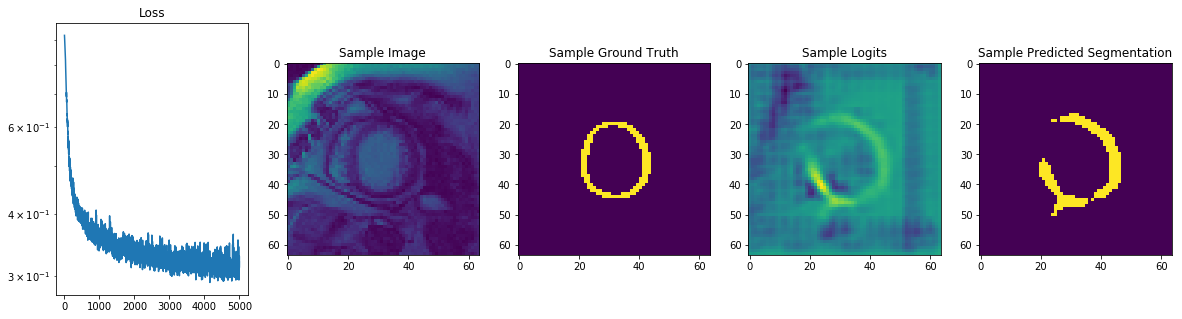

In [69]:
# store the training data as tensors
trainTensor = torch.from_numpy(trainImages[:,None])
segTensor = torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net = SegNet()

# choose a device and  (remember to set Google Colab environment runtime to use GPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# move the net and tensors to device memory
net = net.to(device)
trainTensor = trainTensor.to(device)
segTensor = segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps = 5000
losses = []

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    pred = net(trainTensor)
    if t == 1:
      print('pred shape: ' + str(pred.size()))
      print('segTensor shape: ' + str(segTensor.size()))
    lossval = loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20) == 0:
        print(t,lossval.item())    

# result
sample = np.random.randint(0, pred.shape[0]-1 )  # choose random sample to visualise segmentation the network predicted for it
print('Showing results from random sample: %d' % sample)
pred.shape
predSample=pred[sample,0].cpu().data.numpy()
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(losses)
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[10])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[10])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)